<a href="https://colab.research.google.com/github/GP-FCI-SU/Breast-Cancer-Detection-with-Convolutional-Neural-Networks/blob/master/model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-add this files to your drive : https://drive.google.com/file/d/17Qoc_u3YdAKoYuMvhyW77ocwLRPbW_lx/view?usp=sharing

2-run the next two cells and connect to your drive and extract the files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#to extract files 
import zipfile
local_zip = '/content/drive/My Drive/ddsm-mammography.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/ddsm')

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'2.2.0'

In [ ]:

features={#needed features to feed into our model  
            
            'label_normal': tf.io.FixedLenFeature([], tf.int64),
            'image': tf.io.FixedLenFeature([], tf.string)
        }#we have also the label feature but not used here

#make a function that will applied to the map transformation
def _parse_image_function(example_proto):
  parsed=tf.io.parse_single_example(example_proto,features)
  image = tf.io.decode_raw(parsed["image"], tf.uint8)
  image = tf.cast(image, tf.float32)
  image = tf.reshape(image, shape=[299,299,1])#our image shape and model expected one
  label = tf.cast(parsed["label_normal"], tf.int32) 
  return image,label #atuple of two tensos

In [ ]:
def get_dataset(filenames):
  dataset = tf.data.Dataset.list_files(filenames)
  dataset = dataset.interleave(tf.data.TFRecordDataset,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #dataset = dataset.cache() # This dataset fits in RAM
  #dataset = dataset.repeat()
  #dataset = dataset.shuffle(2048)
  dataset = dataset.batch(batch_size=16) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
def get_training_dataset():
  return get_dataset(["/tmp/ddsm/training10_0/training10_0.tfrecords",
                     "/tmp/ddsm/training10_1/training10_1.tfrecords",
                     "/tmp/ddsm/training10_2/training10_2.tfrecords",
                     "/tmp/ddsm/training10_3/training10_3.tfrecords",
                     "/tmp/ddsm/training10_4/training10_4.tfrecords"]
                     )


def get_validation_dataset():
  return get_dataset("/tmp/ddsm/training10_0/training10_0.tfrecords")


LABEL: 0


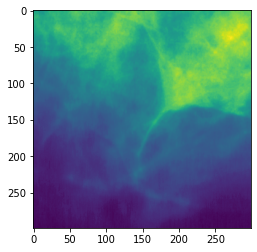

LABEL: 0


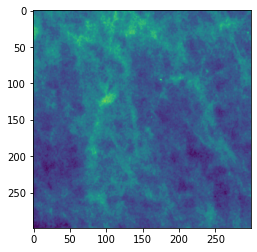

LABEL: 0


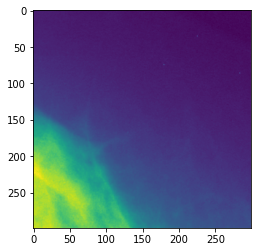

LABEL: 0


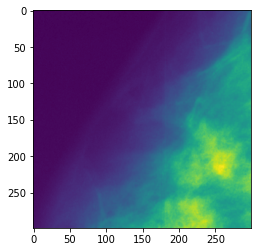

LABEL: 0


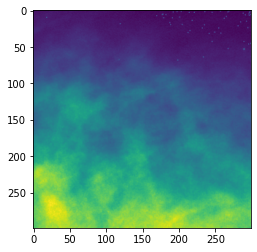

LABEL: 0


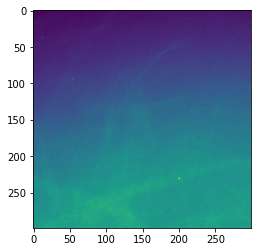

LABEL: 0


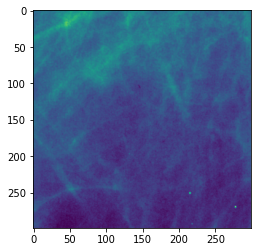

LABEL: 0


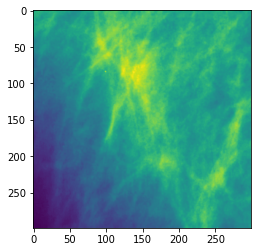

LABEL: 0


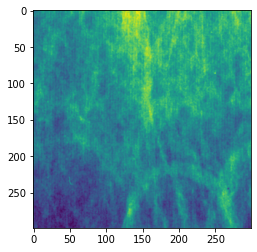

LABEL: 0


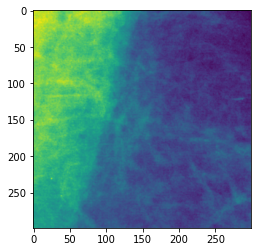

LABEL: 1


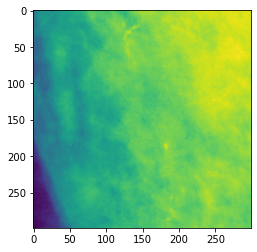

LABEL: 0


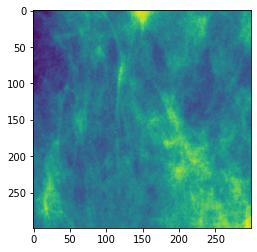

LABEL: 0


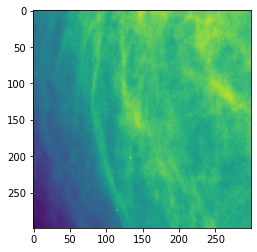

LABEL: 0


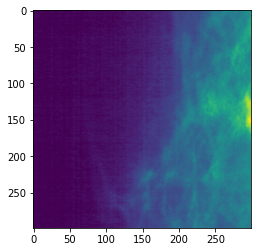

LABEL: 0


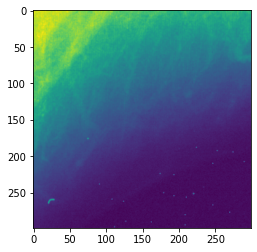

LABEL: 0


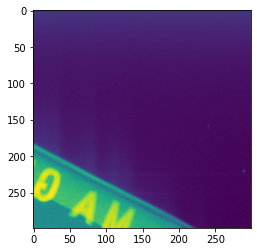

LABEL: 0


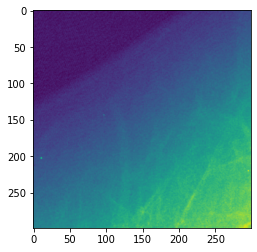

LABEL: 0


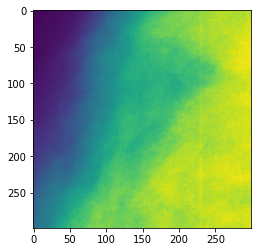

LABEL: 0


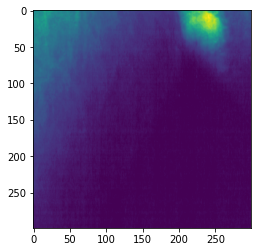

LABEL: 0


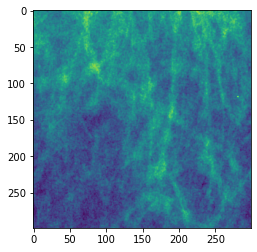

In [ ]:
#display some  images
i=0 
num=20 #number of images u want to disply less than one batch size

for images,labels in get_training_dataset().take(1) :
  for im,lb in zip(images,labels): 
    print("LABEL: "+str(lb.numpy())) 
    plt.imshow( tf.reshape(im, shape=[299,299])  )     
    plt.show()
    i=i+1
    if i>=num:
      break
  
  

In [ ]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D( 32, (3,3), activation='relu', input_shape=(299,299,1)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3),strides=2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
   # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 143, 143, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 71, 71, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 322624)            0

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
history = model.fit(
      get_training_dataset(), 
      epochs=1,
      verbose=1)

NameError: ignored

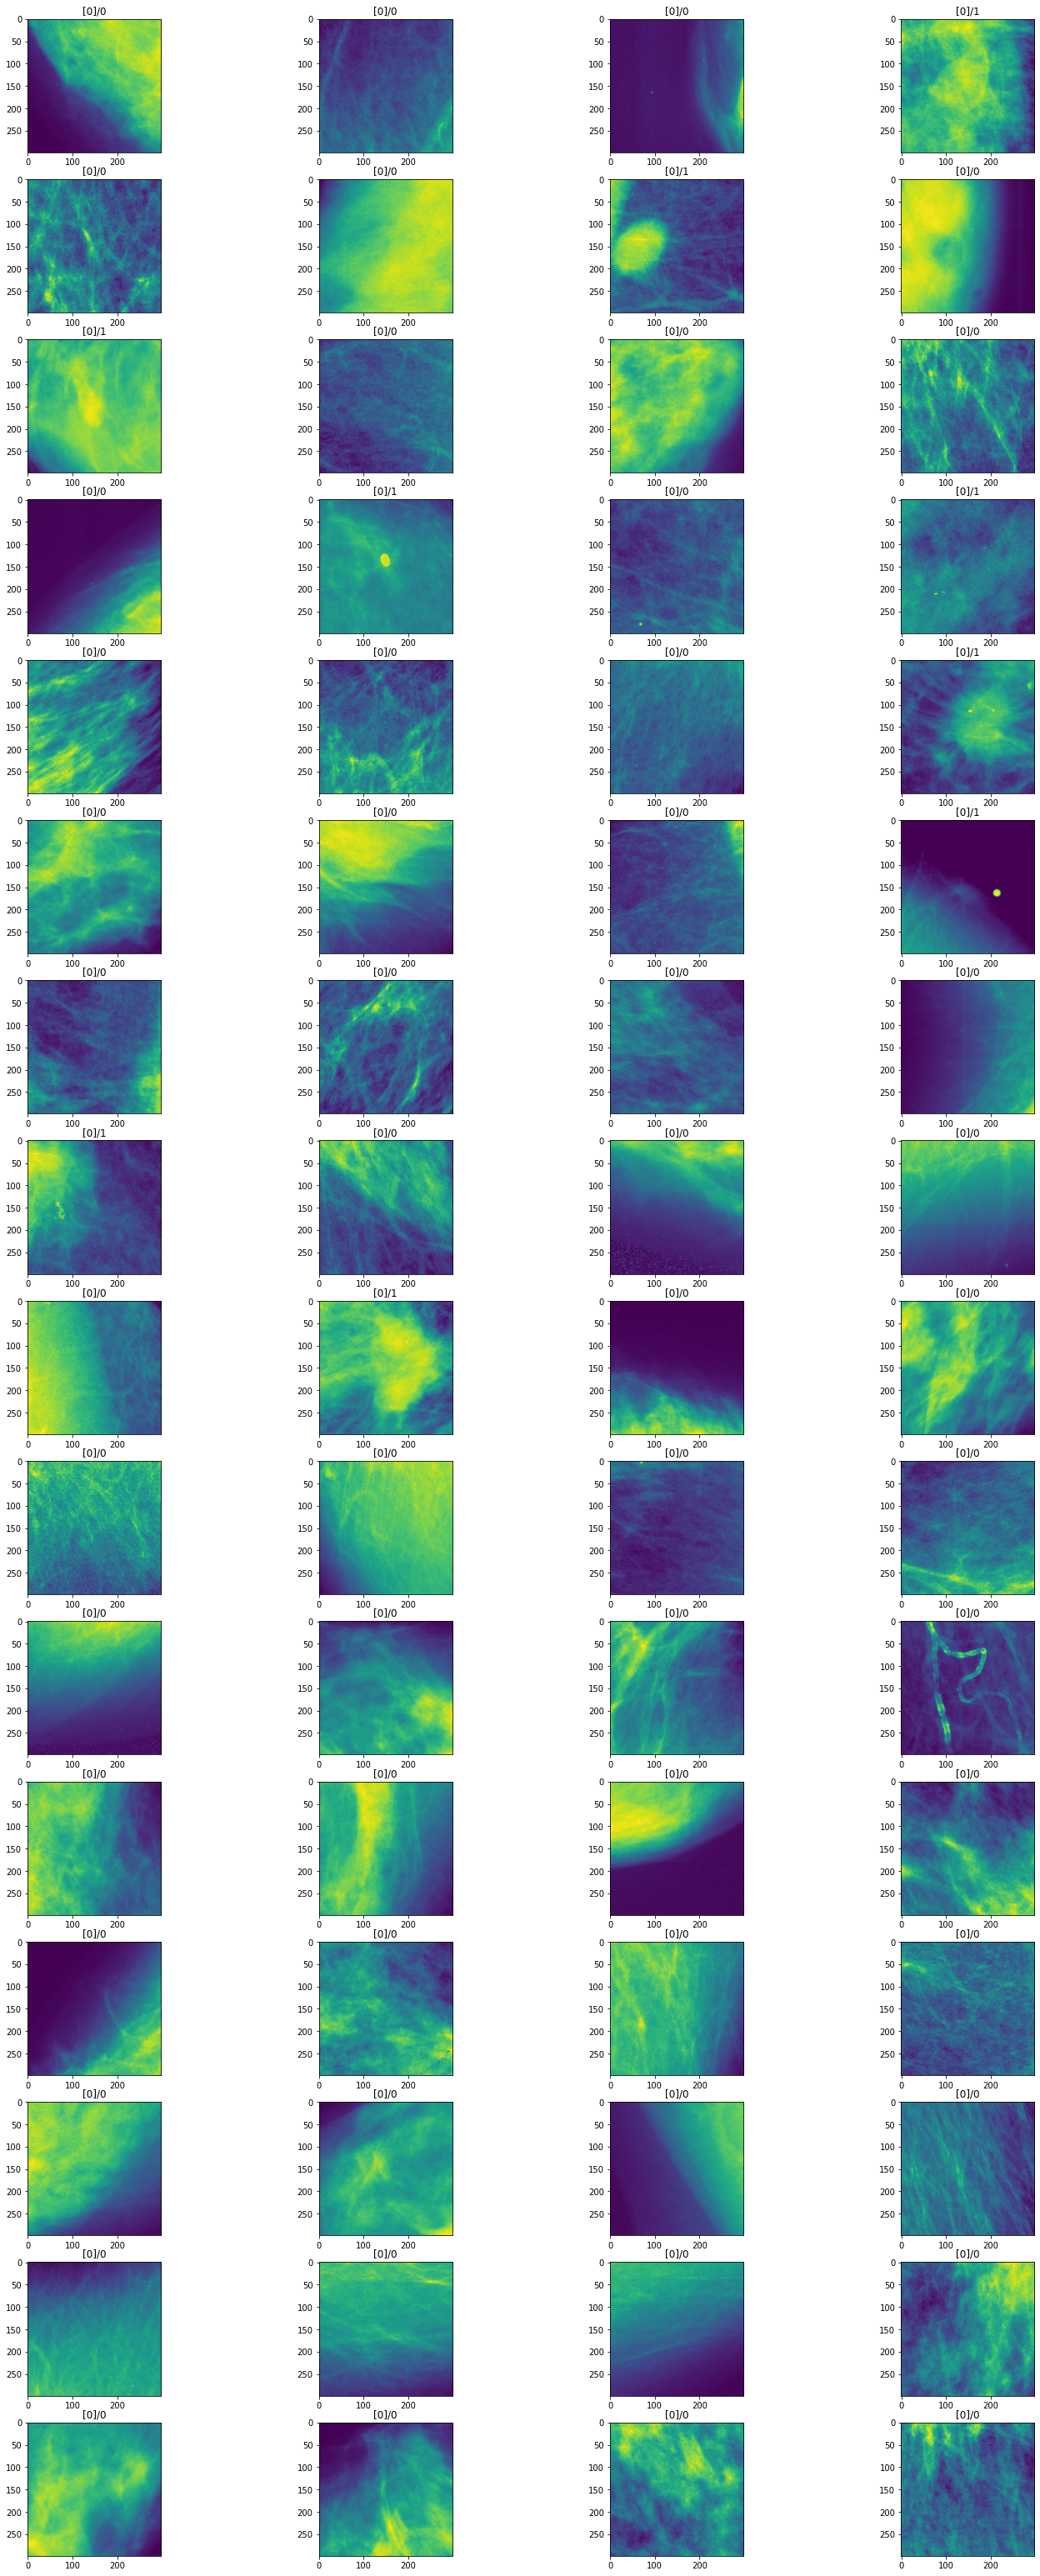

In [ ]:
fig = plt.figure(figsize=(12,28))

cnt=1

ds=get_validation_dataset()

for imgs,lbls in ds.take(1):
  predicted_classes=model.predict_classes(imgs)
  for img,lbl,cl in zip(imgs,lbls,predicted_classes):
    fig.add_subplot(16,4, cnt)
    plt.title('{}/{}'.format(cl,lbl))
    plt.imshow(tf.reshape(img, shape=[299,299]))
    cnt=cnt+1
#print(predicted_classes)
